In [11]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [13]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]

def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    grad_u = grad(u_pde, x_pde)
    u_x = grad_u[:, [0]]
    u_y = grad_u[:, [1]]
    u_z = grad_u[:, [2]]

    u_xx = grad(u_x, x_pde)[:, [0]]
    u_yy = grad(u_y, x_pde)[:, [1]]
    u_zz = grad(u_z, x_pde)[:, [2]]

    pde_value = u_xx + u_yy + u_zz
    return pde_value

In [14]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_test = data['target_test'].item()['u']



In [15]:
x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_test = torch.from_numpy(target_test).float()
print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_test.shape, target_test.shape)

torch.Size([10000, 3]) torch.Size([10000, 1])
torch.Size([2400, 3]) torch.Size([2400, 1])
torch.Size([2000, 3]) torch.Size([2000, 1])


In [16]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [17]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_test = target_test.cuda()


In [18]:

def train(width):
    model  = FCNet(input_dim=3, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [19]:
width_vec = [1000,2000,3000,4000,5000 ]
result_all = []
for width in width_vec:
    print(width,'.....................')
    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

1000 .....................
0 1754.3536376953125
100 1751.4132080078125
200 1749.5523681640625
300 1726.6759033203125
400 1560.7757568359375
500 1045.6767578125
600 510.00274658203125
700 223.3365478515625
800 109.28314971923828
900 61.16117477416992
1000 43.304683685302734
1100 33.61042785644531
1200 26.36345100402832
1300 20.496339797973633
1400 15.946245193481445
1500 12.637998580932617
1600 10.275880813598633
1700 8.581987380981445
1800 7.3407793045043945
1900 6.409055709838867
2000 5.684509754180908
2100 5.2673020362854
2200 4.905158042907715
2300 4.585453033447266
2400 4.300860404968262
2500 4.044821262359619
2600 3.811645984649658
2700 3.6037869453430176
2800 3.4211313724517822
2900 3.251424551010132
3000 3.099721670150757
3100 2.9671716690063477
3200 2.834455966949463
3300 2.7190465927124023
3400 2.6107804775238037
3500 2.5107998847961426
3600 2.4117159843444824
3700 2.3180665969848633
3800 2.225666046142578
3900 2.1360692977905273
4000 2.0471606254577637
4100 1.975379467010498


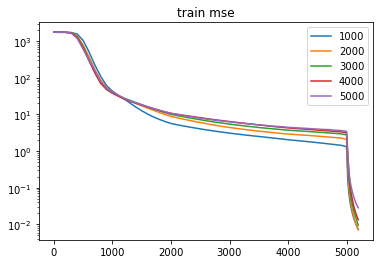

In [20]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

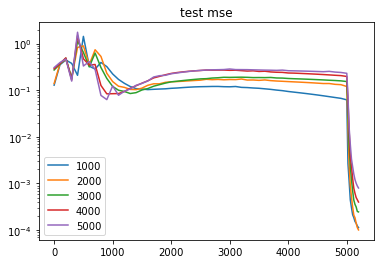

In [21]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [22]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

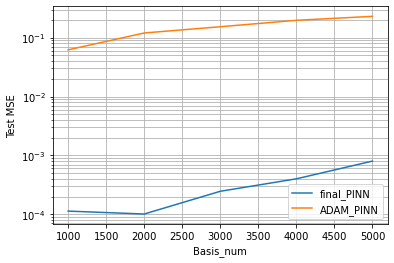

In [23]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')

plt.plot(width_vec, final_mse, label='final_PINN')
plt.plot(width_vec, final_mse_adam, label='ADAM_PINN')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.xlabel('Basis_num')
plt.ylabel('Test MSE')
plt.show()